# LightGCNPlus

### Scope
In this notebook we train different variants of our LightGCNPlus model on different hyperparameters. We then re-train the best performing model and evaluate it on Kaggle's public test set.

### About the model
LightGCNPlus is a graph-based collaborative filtering model that extends the [original LightGCN model](https://arxiv.org/pdf/2002.02126.pdf). The original LightGCN is only able to rank items. We thus refine the model to be able to predict ratings. Our LightGCNPlus model is composed of the following components:
- message passing: $e_u^{(l)} = \sum_{v \in N(u)} \frac{sr_{u,v}}{\sqrt{|N(u)||N(v)|}} e_v^{(l-1)}$, where $sr_{u,v}$ is the standardized rating of user $u$ for item $v$.
- aggregation mechanism: $h_u = \text{concat}(e_u^{(0)}, e_u^{(1)}, ..., e_u^{(L)})$, where $L$ is the number of layers in the message passing mechanism.
- output layer: $\hat{R}_{(i,j)} = \text{MLP}(\text{concat}(h_i, h_j))$, where $\text{MLP}$ is a multi-layer perceptron that projects the embedding couples of observed ratings to the output space.

How our model differs from the original LightGCN:
- In the message passing layer we use the standardized ratings instead of the raw interactions (binary in the original case).
- We use an MLP in the output layer instead of a dot product. This inspired by the [neural collaborative filtering paper](https://arxiv.org/pdf/1708.05031.pdf), in order to predict ratings instead of just ranking unobserved interactions.

### Hyperparameter tuning
The hyperparameters comprise both choices about the models' architecture and the training procedure.
We perform a grid search over the following hyperparameters:
- K: Embedding size.
- L: Number of layers in the message passing mechanism.
- PROJECTIONS: Architecture of the MLP that projects the embedding couples of observed ratings to the output space.

Other hyperparameters such as the learning rate, the batch size, the number of epochs, the optimizer, etc. have been selected based on the results on previous experiments. Thus, to reduce the computational cost of the grid search, the following hyperparameters are kept constant:
- LR: learning rate.
- INIT_EMBS_STD: standard deviation of the normal distribution used to initialize the embeddings.
- WEIGHT_DECAY: weight decay coefficient for the Adam optimizer.
- DROPOUT: dropout rate used in the MLP's hidden layers.
- ACT_FN: activation function used in the MLP's hidden layers.

We also define hyperparameters for the training procedure:
- EPOCHS: number of backpropagation steps.
- STOP_THRESHOLD: minimum improvement in the validation loss to continue training.

### Training
- loss functions:
    - train: $\text{MSE} = \frac{1}{|\Omega|} \sum_{(i,j) \in \Omega} (M_{(i,j)} - \hat{M}_{(i,j)})^2$
    - eval: $\text{RMSE} = \sqrt{\text{MSE}}$
- optimizer: Adam
- Batching: no mini-batching of the training data, doesn't improve performance and slows convergence down. 
- Regularization: dropout and L2 regularization (weight decay in the Adam optimizer).

In [1]:
import torch
from torch import nn
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from train import train_model
from models import LightGCNPlus
from config import DEVICE
from train import train_model
from postprocess import report_training_results
from itertools import product

## 1. Load and Preprocessing

In [2]:
from load import load_train_data
train_df = load_train_data()

In [3]:
from preprocess import preprocess

A_tilde, standardized_train_ratings, train_users, train_items, means, stds, val_users, val_items, orig_val_ratings, standardized_val_ratings = preprocess(train_df)

## 2. Train and Report

In the ideal case one would search over multiple splits of the train and val sets.

In [4]:
# Model and optimizer hyperparameters
INIT_EMBS_STD=0.075
LR=0.1
WEIGHT_DECAY=0.00005
DROPOUT=0.5
ACT_FN = nn.GELU()

# Train loop hyperparameters
EPOCHS = 500
STOP_THRESHOLD=1e-07

# To be searched (example values)
# K=28
# L=4
# PROJECTIONS = (4,)

In [5]:
# Grid
ks = [28, 30, 32]
layers = [3, 4]
projections = [(4,1), (4,), (2,), (1,)]

K=28, L=3, C=(4, 1)
Epoch 0 - Train loss: 1.0017 - Val loss: 1.1661 - Val loss original: 1.2005
Epoch 1 - Train loss: 1.1730 - Val loss: 1.0583 - Val loss original: 1.0874
Epoch 2 - Train loss: 1.0563 - Val loss: 1.0340 - Val loss original: 1.0618
Epoch 3 - Train loss: 1.1820 - Val loss: 1.2178 - Val loss original: 1.2290
Epoch 4 - Train loss: 1.2750 - Val loss: 1.2918 - Val loss original: 1.3347
Epoch 5 - Train loss: 1.3250 - Val loss: 1.0151 - Val loss original: 1.0428
Epoch 6 - Train loss: 1.0096 - Val loss: 1.0138 - Val loss original: 1.0417
Epoch 7 - Train loss: 1.0132 - Val loss: 1.0143 - Val loss original: 1.0425
Epoch 8 - Train loss: 1.0224 - Val loss: 1.0195 - Val loss original: 1.0481
Epoch 9 - Train loss: 1.0125 - Val loss: 1.0131 - Val loss original: 1.0411
Epoch 10 - Train loss: 1.0110 - Val loss: 1.0061 - Val loss original: 1.0336
Epoch 11 - Train loss: 1.0037 - Val loss: 1.0028 - Val loss original: 1.0298
Epoch 12 - Train loss: 1.0028 - Val loss: 1.0004 - Val loss origin

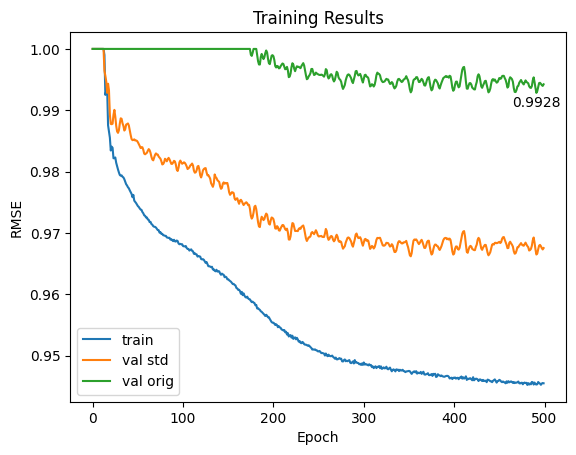

K=28, L=3, C=(4,)
Epoch 0 - Train loss: 1.0044 - Val loss: 1.0739 - Val loss original: 1.1046
Epoch 1 - Train loss: 1.0673 - Val loss: 1.1135 - Val loss original: 1.1293
Epoch 2 - Train loss: 1.1035 - Val loss: 5.8657 - Val loss original: 6.0043
Epoch 3 - Train loss: 5.9501 - Val loss: 1.1568 - Val loss original: 1.1924
Epoch 4 - Train loss: 1.1591 - Val loss: 1.3227 - Val loss original: 1.3527
Epoch 5 - Train loss: 1.3193 - Val loss: 1.0727 - Val loss original: 1.1003
Epoch 6 - Train loss: 1.0841 - Val loss: 3.3211 - Val loss original: 3.3276
Epoch 7 - Train loss: 3.3905 - Val loss: 1.1934 - Val loss original: 1.2265
Epoch 8 - Train loss: 1.2514 - Val loss: 2.1715 - Val loss original: 2.2392
Epoch 9 - Train loss: 2.2068 - Val loss: 1.2400 - Val loss original: 1.2832
Epoch 10 - Train loss: 1.2531 - Val loss: 0.9929 - Val loss original: 1.0197
Epoch 11 - Train loss: 0.9964 - Val loss: 1.0075 - Val loss original: 1.0351
Epoch 12 - Train loss: 1.0081 - Val loss: 1.0167 - Val loss original

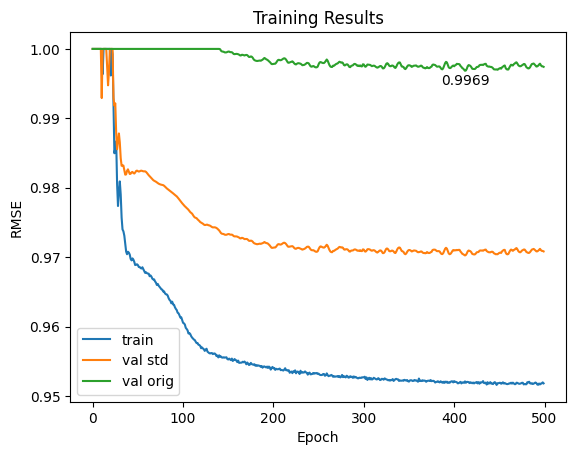

K=28, L=3, C=(2,)
Epoch 0 - Train loss: 1.0040 - Val loss: 1.0399 - Val loss original: 1.0679
Epoch 1 - Train loss: 1.0313 - Val loss: 1.0899 - Val loss original: 1.1146
Epoch 2 - Train loss: 1.0934 - Val loss: 2.2703 - Val loss original: 2.3236
Epoch 3 - Train loss: 2.3055 - Val loss: 1.0270 - Val loss original: 1.0553
Epoch 4 - Train loss: 1.0268 - Val loss: 1.1943 - Val loss original: 1.2255
Epoch 5 - Train loss: 1.1957 - Val loss: 1.0046 - Val loss original: 1.0332
Epoch 6 - Train loss: 1.0020 - Val loss: 1.4872 - Val loss original: 1.4958
Epoch 7 - Train loss: 1.5315 - Val loss: 1.0504 - Val loss original: 1.0812
Epoch 8 - Train loss: 1.0784 - Val loss: 1.3886 - Val loss original: 1.4278
Epoch 9 - Train loss: 1.4049 - Val loss: 1.0942 - Val loss original: 1.1254
Epoch 10 - Train loss: 1.0916 - Val loss: 0.9936 - Val loss original: 1.0205
Epoch 11 - Train loss: 0.9885 - Val loss: 1.0151 - Val loss original: 1.0418
Epoch 12 - Train loss: 1.0111 - Val loss: 1.0113 - Val loss original

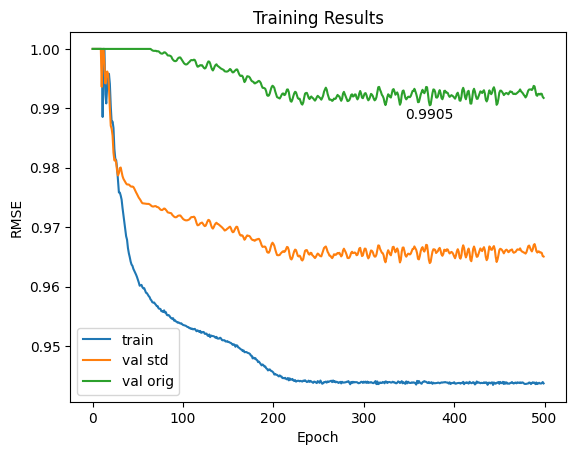

K=28, L=3, C=(1,)
Epoch 0 - Train loss: 1.0000 - Val loss: 1.0225 - Val loss original: 1.0511
Epoch 1 - Train loss: 1.0136 - Val loss: 1.0152 - Val loss original: 1.0422
Epoch 2 - Train loss: 1.0051 - Val loss: 0.9944 - Val loss original: 1.0211
Epoch 3 - Train loss: 0.9824 - Val loss: 1.1014 - Val loss original: 1.1278
Epoch 4 - Train loss: 1.0986 - Val loss: 0.9904 - Val loss original: 1.0170
Epoch 5 - Train loss: 0.9792 - Val loss: 1.0028 - Val loss original: 1.0301
Epoch 6 - Train loss: 0.9966 - Val loss: 1.0125 - Val loss original: 1.0391
Epoch 7 - Train loss: 1.0079 - Val loss: 0.9966 - Val loss original: 1.0235
Epoch 8 - Train loss: 0.9884 - Val loss: 0.9903 - Val loss original: 1.0166
Epoch 9 - Train loss: 0.9791 - Val loss: 0.9870 - Val loss original: 1.0133
Epoch 10 - Train loss: 0.9746 - Val loss: 1.0160 - Val loss original: 1.0437
Epoch 11 - Train loss: 1.0069 - Val loss: 1.0024 - Val loss original: 1.0289
Epoch 12 - Train loss: 0.9901 - Val loss: 1.0002 - Val loss original

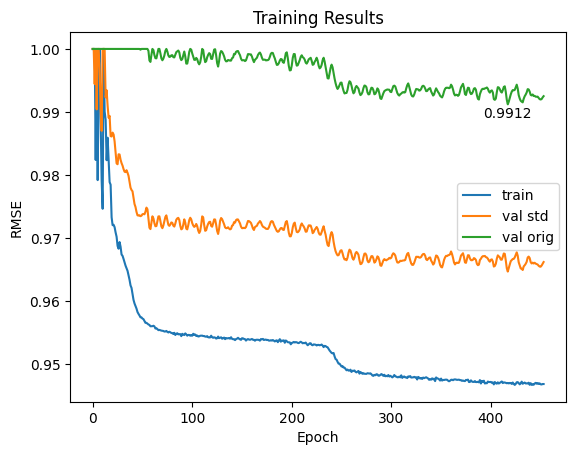

K=28, L=4, C=(4, 1)
Epoch 0 - Train loss: 1.0043 - Val loss: 1.1329 - Val loss original: 1.1661
Epoch 1 - Train loss: 1.1392 - Val loss: 1.0554 - Val loss original: 1.0839
Epoch 2 - Train loss: 1.0646 - Val loss: 2.0486 - Val loss original: 2.0893
Epoch 3 - Train loss: 2.2310 - Val loss: 1.0364 - Val loss original: 1.0619
Epoch 4 - Train loss: 1.0352 - Val loss: 1.0702 - Val loss original: 1.0992
Epoch 5 - Train loss: 1.0926 - Val loss: 1.0344 - Val loss original: 1.0623
Epoch 6 - Train loss: 1.0434 - Val loss: 1.1120 - Val loss original: 1.1389
Epoch 7 - Train loss: 1.1614 - Val loss: 1.0761 - Val loss original: 1.1040
Epoch 8 - Train loss: 1.0823 - Val loss: 1.2369 - Val loss original: 1.2609
Epoch 9 - Train loss: 1.3206 - Val loss: 1.1138 - Val loss original: 1.1408
Epoch 10 - Train loss: 1.1817 - Val loss: 1.0241 - Val loss original: 1.0508
Epoch 11 - Train loss: 1.0424 - Val loss: 1.0196 - Val loss original: 1.0483
Epoch 12 - Train loss: 1.0641 - Val loss: 1.0130 - Val loss origin

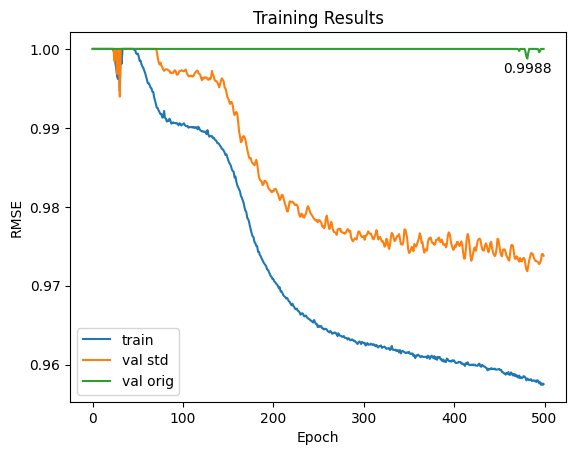

K=28, L=4, C=(4,)
Epoch 0 - Train loss: 1.0022 - Val loss: 1.1760 - Val loss original: 1.2114
Epoch 1 - Train loss: 1.1728 - Val loss: 1.1538 - Val loss original: 1.1752
Epoch 2 - Train loss: 1.1490 - Val loss: 4.2569 - Val loss original: 4.3523
Epoch 3 - Train loss: 4.3424 - Val loss: 1.0315 - Val loss original: 1.0625
Epoch 4 - Train loss: 1.0431 - Val loss: 1.4346 - Val loss original: 1.4587
Epoch 5 - Train loss: 1.4396 - Val loss: 1.1445 - Val loss original: 1.1732
Epoch 6 - Train loss: 1.1594 - Val loss: 1.1694 - Val loss original: 1.1988
Epoch 7 - Train loss: 1.2892 - Val loss: 3.2758 - Val loss original: 3.3096
Epoch 8 - Train loss: 3.4296 - Val loss: 3.0940 - Val loss original: 3.1304
Epoch 9 - Train loss: 3.2083 - Val loss: 1.8658 - Val loss original: 1.9030
Epoch 10 - Train loss: 1.8927 - Val loss: 1.0276 - Val loss original: 1.0548
Epoch 11 - Train loss: 1.0343 - Val loss: 1.4276 - Val loss original: 1.4664
Epoch 12 - Train loss: 1.4480 - Val loss: 1.4660 - Val loss original

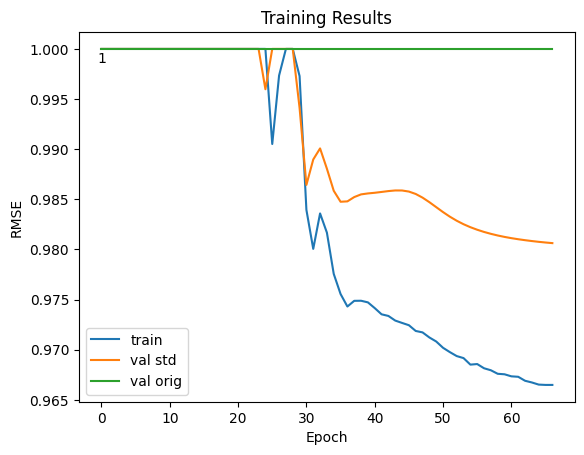

K=28, L=4, C=(2,)
Epoch 0 - Train loss: 1.0019 - Val loss: 1.0483 - Val loss original: 1.0767
Epoch 1 - Train loss: 1.0395 - Val loss: 1.0162 - Val loss original: 1.0434
Epoch 2 - Train loss: 1.0141 - Val loss: 2.7664 - Val loss original: 2.8308
Epoch 3 - Train loss: 2.8240 - Val loss: 1.0054 - Val loss original: 1.0321
Epoch 4 - Train loss: 0.9984 - Val loss: 1.0703 - Val loss original: 1.1011
Epoch 5 - Train loss: 1.0614 - Val loss: 1.1022 - Val loss original: 1.1191
Epoch 6 - Train loss: 1.1143 - Val loss: 1.0716 - Val loss original: 1.0951
Epoch 7 - Train loss: 1.1139 - Val loss: 1.4360 - Val loss original: 1.4742
Epoch 8 - Train loss: 1.5022 - Val loss: 1.0026 - Val loss original: 1.0303
Epoch 9 - Train loss: 1.0593 - Val loss: 1.3114 - Val loss original: 1.3511
Epoch 10 - Train loss: 1.3586 - Val loss: 1.0436 - Val loss original: 1.0740
Epoch 11 - Train loss: 1.0604 - Val loss: 1.2384 - Val loss original: 1.2814
Epoch 12 - Train loss: 1.2490 - Val loss: 1.0684 - Val loss original

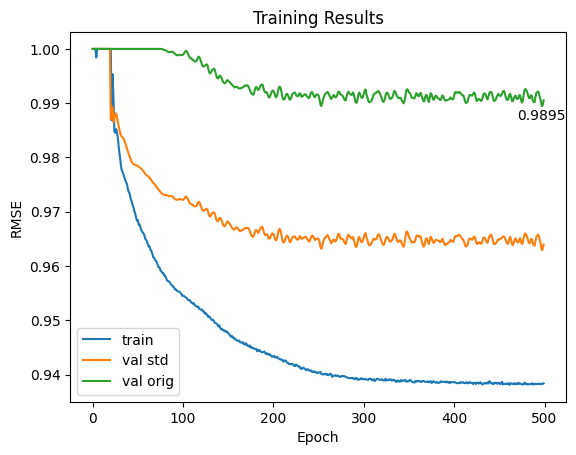

K=28, L=4, C=(1,)
Epoch 0 - Train loss: 1.0000 - Val loss: 1.0357 - Val loss original: 1.0632
Epoch 1 - Train loss: 1.0260 - Val loss: 1.0076 - Val loss original: 1.0351
Epoch 2 - Train loss: 0.9987 - Val loss: 1.0160 - Val loss original: 1.0420
Epoch 3 - Train loss: 1.0059 - Val loss: 1.0656 - Val loss original: 1.0941
Epoch 4 - Train loss: 1.0566 - Val loss: 0.9958 - Val loss original: 1.0225
Epoch 5 - Train loss: 0.9830 - Val loss: 1.0014 - Val loss original: 1.0281
Epoch 6 - Train loss: 0.9910 - Val loss: 0.9931 - Val loss original: 1.0197
Epoch 7 - Train loss: 0.9877 - Val loss: 1.0047 - Val loss original: 1.0317
Epoch 8 - Train loss: 1.0115 - Val loss: 0.9995 - Val loss original: 1.0261
Epoch 9 - Train loss: 1.0058 - Val loss: 0.9866 - Val loss original: 1.0136
Epoch 10 - Train loss: 0.9785 - Val loss: 0.9950 - Val loss original: 1.0221
Epoch 11 - Train loss: 0.9856 - Val loss: 0.9935 - Val loss original: 1.0205
Epoch 12 - Train loss: 0.9860 - Val loss: 0.9893 - Val loss original

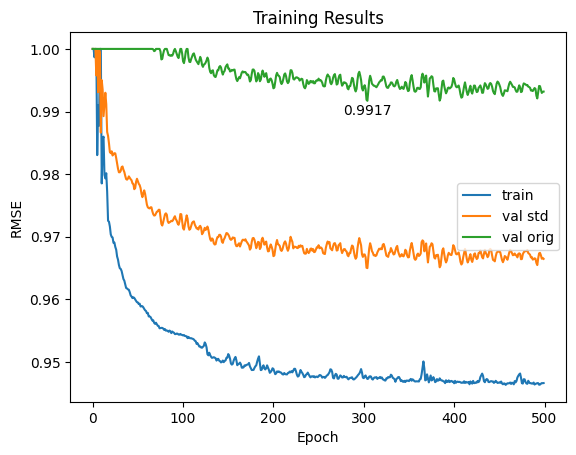

K=30, L=3, C=(4, 1)
Epoch 0 - Train loss: 1.0031 - Val loss: 1.1241 - Val loss original: 1.1566
Epoch 1 - Train loss: 1.1274 - Val loss: 1.0433 - Val loss original: 1.0693
Epoch 2 - Train loss: 1.0562 - Val loss: 1.7293 - Val loss original: 1.7400
Epoch 3 - Train loss: 2.0539 - Val loss: 4.6778 - Val loss original: 4.7827
Epoch 4 - Train loss: 5.1729 - Val loss: 1.2606 - Val loss original: 1.2944
Epoch 5 - Train loss: 1.5167 - Val loss: 1.0187 - Val loss original: 1.0461
Epoch 6 - Train loss: 1.1139 - Val loss: 1.1532 - Val loss original: 1.1828
Epoch 7 - Train loss: 1.1641 - Val loss: 1.3372 - Val loss original: 1.3392
Epoch 8 - Train loss: 1.4691 - Val loss: 1.0950 - Val loss original: 1.1238
Epoch 9 - Train loss: 1.1012 - Val loss: 1.0661 - Val loss original: 1.0931
Epoch 10 - Train loss: 1.0696 - Val loss: 1.0465 - Val loss original: 1.0740
Epoch 11 - Train loss: 1.0418 - Val loss: 1.0394 - Val loss original: 1.0666
Epoch 12 - Train loss: 1.0295 - Val loss: 1.0415 - Val loss origin

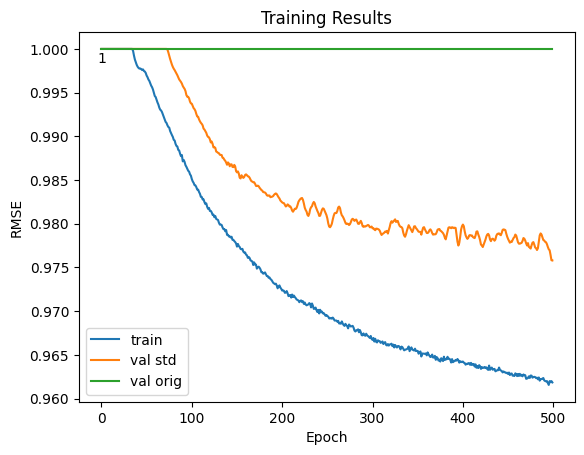

K=30, L=3, C=(4,)
Epoch 0 - Train loss: 1.0015 - Val loss: 1.1153 - Val loss original: 1.1497
Epoch 1 - Train loss: 1.1129 - Val loss: 1.0718 - Val loss original: 1.0933
Epoch 2 - Train loss: 1.0650 - Val loss: 7.4196 - Val loss original: 7.5547
Epoch 3 - Train loss: 7.5230 - Val loss: 1.1962 - Val loss original: 1.2315
Epoch 4 - Train loss: 1.2060 - Val loss: 1.2878 - Val loss original: 1.3167
Epoch 5 - Train loss: 1.2874 - Val loss: 1.1327 - Val loss original: 1.1607
Epoch 6 - Train loss: 1.1730 - Val loss: 2.3597 - Val loss original: 2.3784
Epoch 7 - Train loss: 2.4803 - Val loss: 1.9738 - Val loss original: 2.0098
Epoch 8 - Train loss: 2.1840 - Val loss: 1.4345 - Val loss original: 1.4674
Epoch 9 - Train loss: 1.7099 - Val loss: 2.3285 - Val loss original: 2.3768
Epoch 10 - Train loss: 2.5302 - Val loss: 1.1440 - Val loss original: 1.1668
Epoch 11 - Train loss: 1.3833 - Val loss: 2.1762 - Val loss original: 2.2006
Epoch 12 - Train loss: 2.2763 - Val loss: 1.1497 - Val loss original

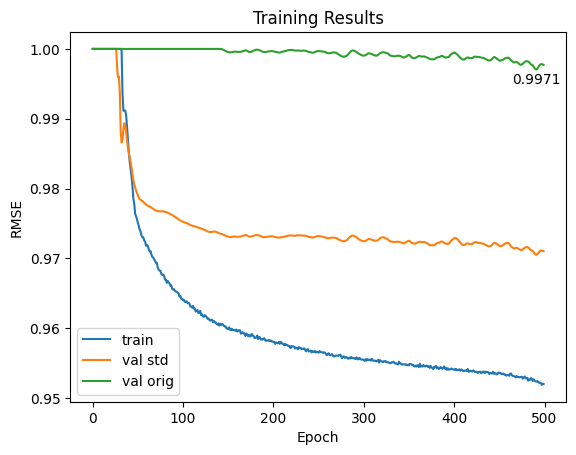

K=30, L=3, C=(2,)
Epoch 0 - Train loss: 1.0037 - Val loss: 1.0917 - Val loss original: 1.1209
Epoch 1 - Train loss: 1.0863 - Val loss: 1.0486 - Val loss original: 1.0705
Epoch 2 - Train loss: 1.0455 - Val loss: 4.1913 - Val loss original: 4.2840
Epoch 3 - Train loss: 4.2906 - Val loss: 1.0777 - Val loss original: 1.1071
Epoch 4 - Train loss: 1.0782 - Val loss: 1.0928 - Val loss original: 1.1214
Epoch 5 - Train loss: 1.0855 - Val loss: 1.0687 - Val loss original: 1.0979
Epoch 6 - Train loss: 1.0626 - Val loss: 1.7441 - Val loss original: 1.7470
Epoch 7 - Train loss: 1.8050 - Val loss: 1.0519 - Val loss original: 1.0796
Epoch 8 - Train loss: 1.1059 - Val loss: 1.5672 - Val loss original: 1.6064
Epoch 9 - Train loss: 1.6122 - Val loss: 1.1292 - Val loss original: 1.1612
Epoch 10 - Train loss: 1.1695 - Val loss: 1.1879 - Val loss original: 1.2105
Epoch 11 - Train loss: 1.2533 - Val loss: 1.1932 - Val loss original: 1.2207
Epoch 12 - Train loss: 1.2454 - Val loss: 1.0061 - Val loss original

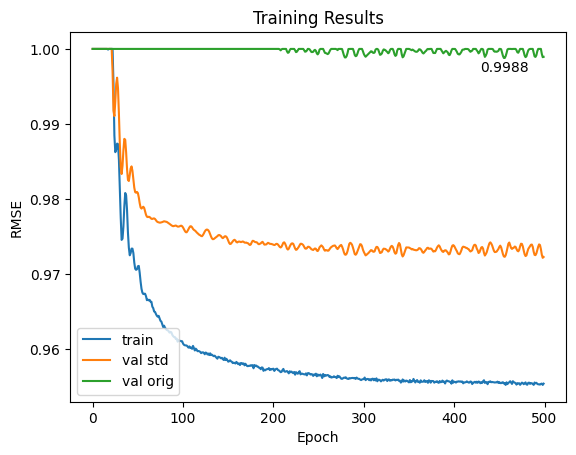

K=30, L=3, C=(1,)
Epoch 0 - Train loss: 1.0001 - Val loss: 1.0438 - Val loss original: 1.0734
Epoch 1 - Train loss: 1.0365 - Val loss: 1.0077 - Val loss original: 1.0344
Epoch 2 - Train loss: 0.9984 - Val loss: 1.0678 - Val loss original: 1.0963
Epoch 3 - Train loss: 1.0632 - Val loss: 1.0371 - Val loss original: 1.0644
Epoch 4 - Train loss: 1.0294 - Val loss: 1.0012 - Val loss original: 1.0278
Epoch 5 - Train loss: 0.9891 - Val loss: 1.0072 - Val loss original: 1.0344
Epoch 6 - Train loss: 0.9966 - Val loss: 1.0067 - Val loss original: 1.0342
Epoch 7 - Train loss: 0.9973 - Val loss: 0.9996 - Val loss original: 1.0266
Epoch 8 - Train loss: 0.9924 - Val loss: 1.0128 - Val loss original: 1.0380
Epoch 9 - Train loss: 1.0063 - Val loss: 1.0369 - Val loss original: 1.0649
Epoch 10 - Train loss: 1.0461 - Val loss: 0.9872 - Val loss original: 1.0132
Epoch 11 - Train loss: 0.9738 - Val loss: 0.9944 - Val loss original: 1.0200
Epoch 12 - Train loss: 0.9825 - Val loss: 0.9914 - Val loss original

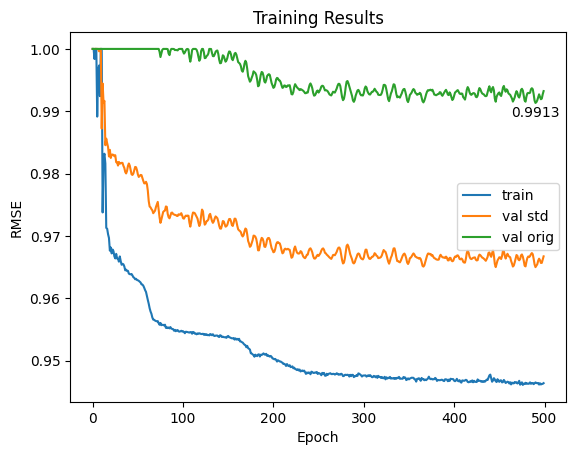

K=30, L=4, C=(4, 1)
Epoch 0 - Train loss: 1.0071 - Val loss: 1.1169 - Val loss original: 1.1461
Epoch 1 - Train loss: 1.1177 - Val loss: 1.0178 - Val loss original: 1.0455
Epoch 2 - Train loss: 1.0201 - Val loss: 1.1933 - Val loss original: 1.2164
Epoch 3 - Train loss: 1.3253 - Val loss: 1.4431 - Val loss original: 1.4706
Epoch 4 - Train loss: 1.5061 - Val loss: 1.0268 - Val loss original: 1.0553
Epoch 5 - Train loss: 1.0374 - Val loss: 1.0199 - Val loss original: 1.0485
Epoch 6 - Train loss: 1.0199 - Val loss: 1.0281 - Val loss original: 1.0542
Epoch 7 - Train loss: 1.0290 - Val loss: 1.0326 - Val loss original: 1.0578
Epoch 8 - Train loss: 1.0397 - Val loss: 1.0123 - Val loss original: 1.0391
Epoch 9 - Train loss: 1.0107 - Val loss: 1.0056 - Val loss original: 1.0326
Epoch 10 - Train loss: 1.0006 - Val loss: 1.0081 - Val loss original: 1.0356
Epoch 11 - Train loss: 1.0006 - Val loss: 1.0094 - Val loss original: 1.0372
Epoch 12 - Train loss: 1.0018 - Val loss: 1.0061 - Val loss origin

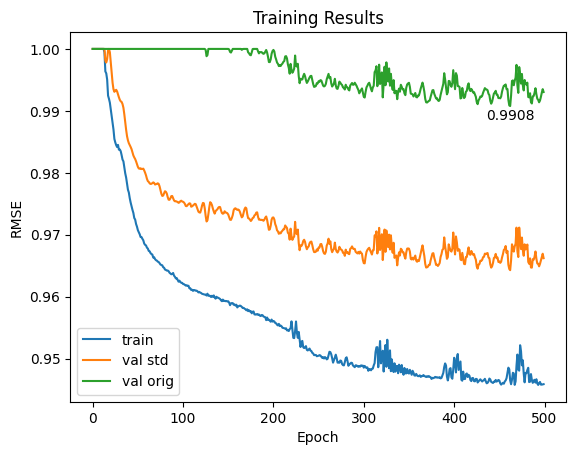

K=30, L=4, C=(4,)
Epoch 0 - Train loss: 1.0000 - Val loss: 1.1576 - Val loss original: 1.1916
Epoch 1 - Train loss: 1.1527 - Val loss: 1.3998 - Val loss original: 1.4234
Epoch 2 - Train loss: 1.3955 - Val loss: 2.8049 - Val loss original: 2.8814
Epoch 3 - Train loss: 2.8430 - Val loss: 1.1598 - Val loss original: 1.1722
Epoch 4 - Train loss: 1.1643 - Val loss: 1.2227 - Val loss original: 1.2464
Epoch 5 - Train loss: 1.2126 - Val loss: 1.8790 - Val loss original: 1.9005
Epoch 6 - Train loss: 1.8975 - Val loss: 1.0256 - Val loss original: 1.0550
Epoch 7 - Train loss: 1.0299 - Val loss: 1.4650 - Val loss original: 1.5049
Epoch 8 - Train loss: 1.4741 - Val loss: 1.0242 - Val loss original: 1.0483
Epoch 9 - Train loss: 1.0235 - Val loss: 1.0804 - Val loss original: 1.1105
Epoch 10 - Train loss: 1.0834 - Val loss: 1.1012 - Val loss original: 1.1309
Epoch 11 - Train loss: 1.1061 - Val loss: 1.0653 - Val loss original: 1.0867
Epoch 12 - Train loss: 1.0756 - Val loss: 1.0586 - Val loss original

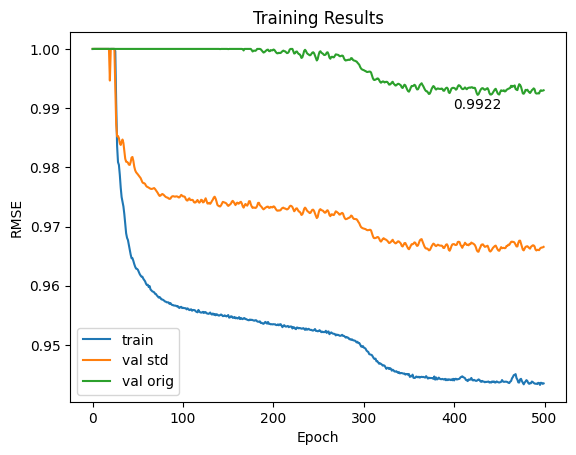

K=30, L=4, C=(2,)
Epoch 0 - Train loss: 1.0044 - Val loss: 1.0394 - Val loss original: 1.0686
Epoch 1 - Train loss: 1.0319 - Val loss: 1.0264 - Val loss original: 1.0512
Epoch 2 - Train loss: 1.0207 - Val loss: 3.0195 - Val loss original: 3.0853
Epoch 3 - Train loss: 3.0831 - Val loss: 1.0442 - Val loss original: 1.0737
Epoch 4 - Train loss: 1.0396 - Val loss: 1.1506 - Val loss original: 1.1803
Epoch 5 - Train loss: 1.1430 - Val loss: 1.0240 - Val loss original: 1.0513
Epoch 6 - Train loss: 1.0347 - Val loss: 2.5064 - Val loss original: 2.5318
Epoch 7 - Train loss: 2.6054 - Val loss: 1.0159 - Val loss original: 1.0426
Epoch 8 - Train loss: 1.0499 - Val loss: 1.2257 - Val loss original: 1.2655
Epoch 9 - Train loss: 1.2372 - Val loss: 1.1470 - Val loss original: 1.1671
Epoch 10 - Train loss: 1.1688 - Val loss: 1.3217 - Val loss original: 1.3435
Epoch 11 - Train loss: 1.3544 - Val loss: 1.0679 - Val loss original: 1.0955
Epoch 12 - Train loss: 1.0713 - Val loss: 1.0031 - Val loss original

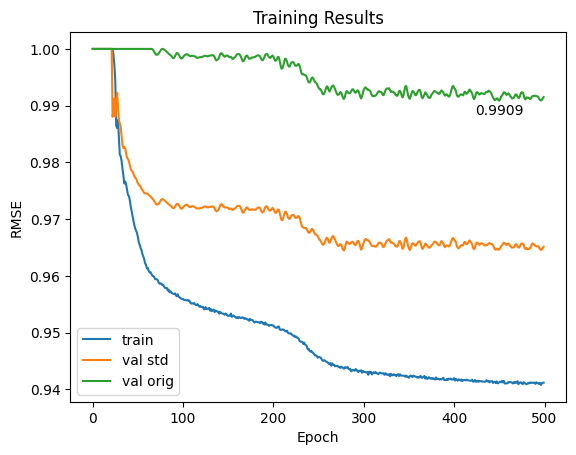

K=30, L=4, C=(1,)
Epoch 0 - Train loss: 1.0094 - Val loss: 1.0271 - Val loss original: 1.0555
Epoch 1 - Train loss: 1.0192 - Val loss: 1.0237 - Val loss original: 1.0499
Epoch 2 - Train loss: 1.0153 - Val loss: 1.0883 - Val loss original: 1.1166
Epoch 3 - Train loss: 1.0850 - Val loss: 1.0372 - Val loss original: 1.0635
Epoch 4 - Train loss: 1.0287 - Val loss: 1.0051 - Val loss original: 1.0319
Epoch 5 - Train loss: 0.9938 - Val loss: 1.0095 - Val loss original: 1.0368
Epoch 6 - Train loss: 0.9996 - Val loss: 1.0108 - Val loss original: 1.0380
Epoch 7 - Train loss: 1.0017 - Val loss: 1.0069 - Val loss original: 1.0332
Epoch 8 - Train loss: 0.9976 - Val loss: 0.9987 - Val loss original: 1.0245
Epoch 9 - Train loss: 0.9882 - Val loss: 0.9882 - Val loss original: 1.0141
Epoch 10 - Train loss: 0.9756 - Val loss: 0.9913 - Val loss original: 1.0173
Epoch 11 - Train loss: 0.9776 - Val loss: 0.9878 - Val loss original: 1.0141
Epoch 12 - Train loss: 0.9722 - Val loss: 0.9854 - Val loss original

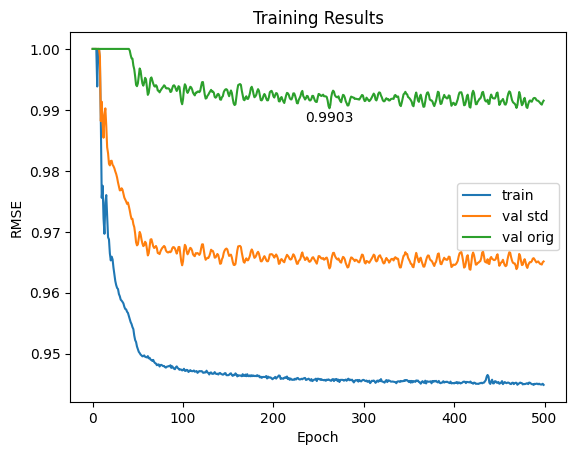

K=32, L=3, C=(4, 1)
Epoch 0 - Train loss: 1.0024 - Val loss: 1.0950 - Val loss original: 1.1233
Epoch 1 - Train loss: 1.0907 - Val loss: 1.0347 - Val loss original: 1.0632
Epoch 2 - Train loss: 1.1207 - Val loss: 3.9398 - Val loss original: 4.0050
Epoch 3 - Train loss: 4.2378 - Val loss: 4.7244 - Val loss original: 4.8205
Epoch 4 - Train loss: 5.1353 - Val loss: 1.2449 - Val loss original: 1.2663
Epoch 5 - Train loss: 1.4106 - Val loss: 2.2020 - Val loss original: 2.1981
Epoch 6 - Train loss: 2.5412 - Val loss: 1.2259 - Val loss original: 1.2422
Epoch 7 - Train loss: 1.3469 - Val loss: 1.0797 - Val loss original: 1.1093
Epoch 8 - Train loss: 1.1365 - Val loss: 1.1280 - Val loss original: 1.1451
Epoch 9 - Train loss: 1.4309 - Val loss: 1.3543 - Val loss original: 1.3923
Epoch 10 - Train loss: 1.8360 - Val loss: 1.4683 - Val loss original: 1.4969
Epoch 11 - Train loss: 1.7954 - Val loss: 1.3853 - Val loss original: 1.4255
Epoch 12 - Train loss: 1.5115 - Val loss: 1.0507 - Val loss origin

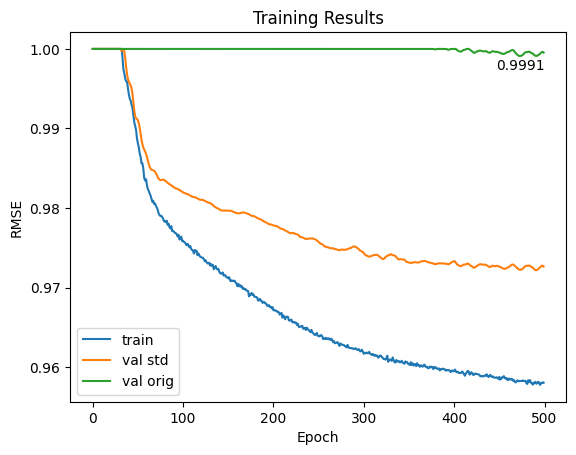

K=32, L=3, C=(4,)
Epoch 0 - Train loss: 1.0017 - Val loss: 1.1129 - Val loss original: 1.1447
Epoch 1 - Train loss: 1.1085 - Val loss: 1.0452 - Val loss original: 1.0726
Epoch 2 - Train loss: 1.0466 - Val loss: 1.4024 - Val loss original: 1.4558
Epoch 3 - Train loss: 1.3840 - Val loss: 2.2780 - Val loss original: 2.3129
Epoch 4 - Train loss: 2.2900 - Val loss: 1.0840 - Val loss original: 1.1085
Epoch 5 - Train loss: 1.0825 - Val loss: 1.0376 - Val loss original: 1.0658
Epoch 6 - Train loss: 1.0337 - Val loss: 1.4211 - Val loss original: 1.4693
Epoch 7 - Train loss: 1.4355 - Val loss: 1.0410 - Val loss original: 1.0707
Epoch 8 - Train loss: 1.0418 - Val loss: 1.0648 - Val loss original: 1.0919
Epoch 9 - Train loss: 1.0708 - Val loss: 1.1053 - Val loss original: 1.1298
Epoch 10 - Train loss: 1.1148 - Val loss: 1.0556 - Val loss original: 1.0856
Epoch 11 - Train loss: 1.0802 - Val loss: 1.0162 - Val loss original: 1.0448
Epoch 12 - Train loss: 1.0622 - Val loss: 1.0247 - Val loss original

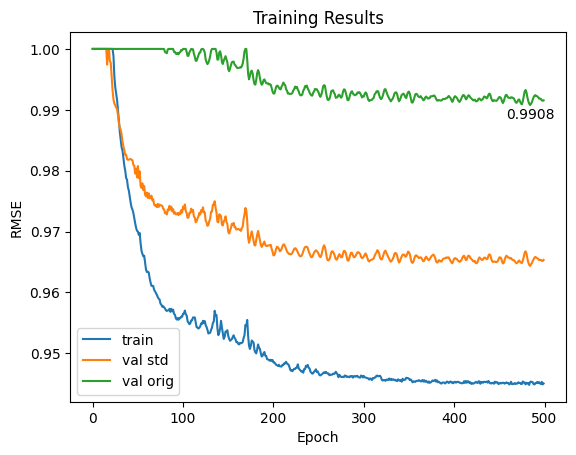

K=32, L=3, C=(2,)
Epoch 0 - Train loss: 1.0008 - Val loss: 1.0403 - Val loss original: 1.0699
Epoch 1 - Train loss: 1.0328 - Val loss: 1.0300 - Val loss original: 1.0541
Epoch 2 - Train loss: 1.0247 - Val loss: 3.2977 - Val loss original: 3.3765
Epoch 3 - Train loss: 3.3520 - Val loss: 1.0512 - Val loss original: 1.0811
Epoch 4 - Train loss: 1.0440 - Val loss: 1.0769 - Val loss original: 1.1050
Epoch 5 - Train loss: 1.0667 - Val loss: 1.0232 - Val loss original: 1.0500
Epoch 6 - Train loss: 1.0349 - Val loss: 1.8889 - Val loss original: 1.9230
Epoch 7 - Train loss: 1.9628 - Val loss: 1.2013 - Val loss original: 1.2318
Epoch 8 - Train loss: 1.2238 - Val loss: 1.4843 - Val loss original: 1.5292
Epoch 9 - Train loss: 1.4970 - Val loss: 1.1074 - Val loss original: 1.1410
Epoch 10 - Train loss: 1.1057 - Val loss: 1.0221 - Val loss original: 1.0490
Epoch 11 - Train loss: 1.0252 - Val loss: 1.0322 - Val loss original: 1.0590
Epoch 12 - Train loss: 1.0464 - Val loss: 1.0113 - Val loss original

In [6]:
# Tuning LightGCNPlus
results = {
    "min_val_losses": [],
    "params": []
}
for K in ks:
    for L in layers:
        for C in projections:
            model = LightGCNPlus(A_tilde, ACT_FN, K, L, INIT_EMBS_STD, DROPOUT, C).to(DEVICE)
            optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
            loss_fn = nn.MSELoss()
            print(f"K={K}, L={L}, C={C}")
            train_rmse, val_rmse_std, val_rmse_orig = train_model(model, optimizer, loss_fn, train_users, train_items, standardized_train_ratings, val_users, val_items, orig_val_ratings, standardized_val_ratings, means, stds, EPOCHS, STOP_THRESHOLD, False, verbosity=1)
            report_training_results(train_rmse, val_rmse_std, val_rmse_orig)
            
            results["min_val_losses"].append(min(val_rmse_orig))
            results["params"].append((K, L, C))

# Report best hyperparameters
best_idx = np.argmin(results["min_val_losses"])
print("Best hyperparameters:")
print(results["params"][best_idx])
print("Best val loss:")
print(results["min_val_losses"][best_idx])

## 3. Retrain model on best hyperparam combo

Epoch 0 - Train loss: 1.0028 - Val loss: 1.0675 - Val loss original: 1.0978
Epoch 1 - Train loss: 1.0752 - Val loss: 1.1325 - Val loss original: 1.1528
Epoch 2 - Train loss: 1.1303 - Val loss: 6.0507 - Val loss original: 6.1461
Epoch 3 - Train loss: 6.1166 - Val loss: 1.2829 - Val loss original: 1.3202
Epoch 4 - Train loss: 1.2988 - Val loss: 1.2538 - Val loss original: 1.2831
Epoch 5 - Train loss: 1.2625 - Val loss: 1.0055 - Val loss original: 1.0347
Epoch 6 - Train loss: 1.0309 - Val loss: 4.3018 - Val loss original: 4.3045
Epoch 7 - Train loss: 4.3962 - Val loss: 1.0598 - Val loss original: 1.0917
Epoch 8 - Train loss: 1.1532 - Val loss: 1.9465 - Val loss original: 1.9966
Epoch 9 - Train loss: 1.9870 - Val loss: 1.1385 - Val loss original: 1.1748
Epoch 10 - Train loss: 1.1634 - Val loss: 1.1865 - Val loss original: 1.2186
Epoch 11 - Train loss: 1.2121 - Val loss: 1.1567 - Val loss original: 1.1955
Epoch 12 - Train loss: 1.2128 - Val loss: 1.1610 - Val loss original: 1.1711
Epoch 13 

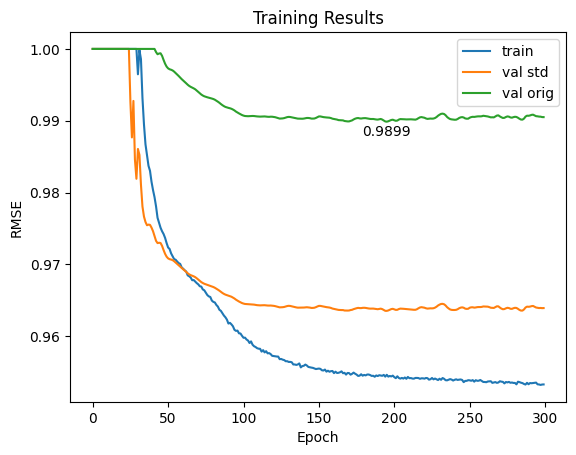

In [ ]:
# Retrain best model 
EPOCHS = 1000
K, L, C = results["params"][best_idx]
# K, L, C = (28, 3, (4,))

model = LightGCNPlus(A_tilde, ACT_FN, K, L, INIT_EMBS_STD, DROPOUT, C).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
loss_fn = nn.MSELoss()

train_rmse, val_rmse_std, val_rmse_orig = train_model(model, optimizer, loss_fn, train_users, train_items, standardized_train_ratings, val_users, val_items, orig_val_ratings, standardized_val_ratings, means, stds, EPOCHS, STOP_THRESHOLD, True, verbosity=1)
report_training_results(train_rmse, val_rmse_std, val_rmse_orig)

## 4. Post-Process and generate submission

min: -0.9210724
max: -0.012571588
mean: -0.48892415


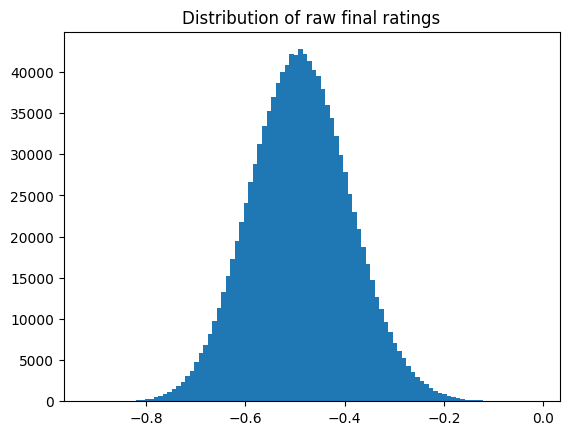

min: 1.1084856647854382
max: 4.5701391681156895
mean: 3.356967516983189
count_over_5: 0
count_under_1: 0

min: 1.1084856647854382
max: 4.5701391681156895
mean: 3.356967516983189


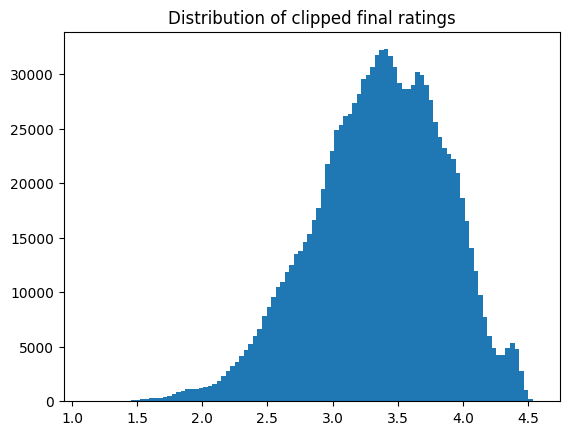

In [ ]:
from postprocess import postprocess
postprocess(LightGCNPlus, means, stds)